# 2022 EY Data Science Challenge
## Model Building - Level 3

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|1    | Australia                     | Coarse (4km)  | 1 of 23 species  | TerraClimate                                                  |
| 2         | Australia, Costa Rica         | Moderate (1km) | 5 of 23 species       | TerraClimate, Sentinel-2                                      |
|***3***     | Australia, Costa Rica,<br>Europe | Fine (10m)   | 23 of all species       | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will demonstrate a complex model workflow that can form a basis for developing a comprehensive solution to the challenge. As specified in the third row of the table above, this model will be trained on three international regions at the finest spatial resolution (10m x 10m), predicting all 23 target species against all available frog occurrence data. The model will be trained with all of the available data sources explored in the supplementary notebooks provided for the challenge, namely [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate), [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a), [Land Cover](https://planetarycomputer.microsoft.com/dataset/group/io-land-cover), [JRC Global Surface Water](https://planetarycomputer.microsoft.com/dataset/jrc-gsw), and [Copernicus Digital Elevation](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30). We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 

Most of the functions present in this notebook were adapted from the following notebooks:
- [GBIF/Frog](Frogs.ipynb)
- [TerraClimate/Weather](Weather.ipynb)
- [Sentinel-2](Weather.ipynb)
- [Land Cover](Weather.ipynb)
- [JRC Global Surface Water](Weather.ipynb)
- [Copernicus Digital Elevation](Weather.ipynb)

`UPDATE LINKS^`

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think is best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
from itertools import cycle

# Data science
import pandas as pd
import numpy as np

# Image processing
from scipy.ndimage import convolve

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio
import rioxarray as rio

import fsspec
# import xrspatial.multispectral as ms

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
import gc

# Folder to store extracted files
# storage_path = './penrith_data/'
storage_path = './data/'

# Path to data folder with provided material
data_path = './data/'

### Jupyter Memory

For any advanced workflow, it is essential that you have enough memory allocated to Jupyter to facilitate high volume data processing. Often the default memory allocation is quite low, at about 0.5-1GB. Depending on your specific environment, you should follow the relevant documentation online to ensure your notebook environment can handle the large workflows we will be exploring. The most memory intensive component of the notebook is the [Submission](#Submission) phase, where we create prediciton masks for the entirety of each test region. 10GB of memory should be enough to run this specific demonstration notebook, but we would recommend allocating the majority of your RAM especially when you are collecting and processing your own training and testing data.

For the JupyterHub environment that comes with the recommended VM environment for this challenge, this is done by changing the byte allocation in `/etc/jupyterhub/default_jupyter_config.py`. The specific parameter to change is `max_buffer_size` which we have set to 10GB (10737418240 bytes). Additionally, the `iopub_data_rate_limit` is also worth changing if the workflow involves visualising large amounts of data.

```
c.NotebookApp.max_buffer_size = 10737418240
c.NotebookApp.iopub_data_rate_limit = 10737418240
```



In this notebook, we only pull in features for the specific frog occurrence locations themselves, rather than loading in the entire satellite image for a region. This allows us to create a richer, broader training set that covers a large area without having to load in data for the entire region. When it comes to visualising our model over the test regions in the [Submission](#Submission) phase, it will become necessary to load in the entire region. This is when your RAM allocation will matter the most. Even with more RAM allocated, the resolution of the satellite data we're working with will quickly become too much for some operations. In this case, consider saving processing products to file to avoid re-running processing operations every time, clear variables with the `del` key if they are no longer in use, and optimise your processing code to minimise memory usage.

Here are some notes on Jupyter and how it handles memory. These may come in handy when troubleshooting

- **The kernel will die when it runs out of memory**, without explicitly prompting you that it is a memory issue. If you find you are having to restart your kernel when running a certain cell, it is likely that you have exceeded the memory allocation for Jupyter.

- Even if your code is memory-optimised and is not saving large datasets to variable names, sometimes Jupyter contains hidden pointers to these objects which can hog memory. For this reason, it is sometimes necessary to **restart the kernel after large processing operations** and load in the resultant data from file. This should free up any stranded memory.


To monitor the kernel's memory usage, consider using commands such as `htop` in the VM's terminal. 


### Response Variable

#### Gathering Frog Data

For this demonstration, we will constrain our search to frogs in the Greater Sydney area. This gives a varied landscape of bushland, plains, rivers, and urban areas.

Text(0.5, 1.0, 'Greater Sydney, NSW')

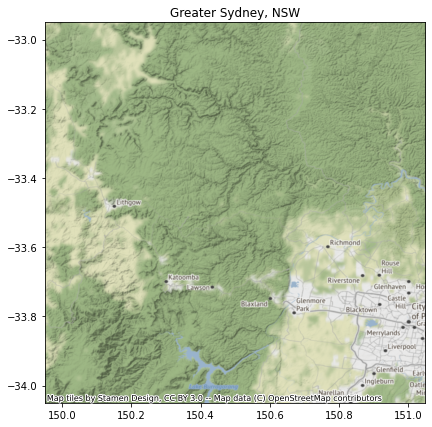

In [2]:
# Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.00, -34.00)  # Lower-left corner
max_lon, max_lat = (151.00, -33.00)  # Upper-right corner

# Penrith, NSW
# region_name = 'Penrith, NSW'
# min_lon, min_lat = (150.50, -34.10)  # Lower-left corner
# max_lon, max_lat = (150.80, -33.40)  # Upper-right corner

# region_name = 'Sydney, NSW'
# min_lon, min_lat = (151.20, -33.70)  # Lower-left corner
# max_lon, max_lat = (151.35, -33.60)  # Upper-right corner

bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title(region_name)

Before we can build our model, we need to query the GBIF API to obtain the frog occurrence data for our region. If you have not checked out the [frog notebook](Frogs.ipynb) yet, we recommend you do before moving on so you can better understand the following functions. The code from that notebook is wrapped up in the `get_frogs` function defined below. This function will obtain all frog occurrences for the given region in the five years from the start of 2015 to the end of 2019. It returns a geopandas dataframe of each occurrence, its species, and its latitude and longitude coordinates. The challenge is to predict the habitats of the 23 species specified in the ['australian_frogs.csv'](australian_frogs.csv) file. Note that not all 23 will be present for a given area.

We will take all frog species to start, and will flag the 23 species of importance later.

In [3]:
def get_frogs(bbox, query_params, crs = {'init':'epsg:4326'}, orderKey="952", verbose=False):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""

    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    offset = 0
    parameters = {
        **query_params,
        "orderKey":orderKey, # The order Anura (frogs) is indicated by key 952
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit,
        "offset":offset
    }

    # Query API
    frogs = pd.DataFrame()
    while True:
        # Fetch results
        parameters['offset'] = offset
        response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
        total = response['count']

        # Print progress
        print(f"{offset} of {total}") if verbose else None

        # Add results to dataframe
        frogs = frogs.append(
            pd.DataFrame(response['results'])
            [["decimalLatitude", "decimalLongitude", "species", "speciesKey"]]
        )
        if response['endOfRecords']:
            break
        offset += limit

    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs

In [4]:
# Pass in the date range to the GBIF API
gbif_api_params = {"year":"2015,2019"}

# Get frogs!
# all_frog_data = get_frogs(bbox, gbif_api_params, verbose=True)
# all_frog_data.to_csv(storage_path+'all_frogs_GWS_2015_2019.csv', index=None)
all_frog_data = pd.read_csv(storage_path+'all_frogs_GWS_2015_2019.csv')

# all_frog_data = get_frogs(bbox, gbif_api_params, verbose=True)
# all_frog_data.to_csv(storage_path+'all_frogs_Penrith_2015_2019.csv', index=None)
# all_frog_data = pd.read_csv(storage_path+'all_frogs_Penrith_2015_2019.csv')

all_frog_data.sample(10, random_state=420)

,decimalLatitude,decimalLongitude,species,speciesKey,geometry
9452,-33.734004,150.376148,Uperoleia laevigata,2424630.0,POINT (150.376148 -33.734004)
1880,-33.756226,150.623049,Limnodynastes peronii,2429583.0,POINT (150.623049 -33.756226)
618,-33.256782,150.166802,Litoria peronii,2427831.0,POINT (150.166802 -33.256782)
8355,-33.507239,150.371471,Litoria peronii,2427831.0,POINT (150.371471 -33.507239)
2429,-33.621495,150.278631,Litoria verreauxii,2427755.0,POINT (150.278631 -33.621495)
7676,-33.606182,150.928594,Uperoleia laevigata,2424630.0,POINT (150.928594 -33.606182)
4715,-33.413674,150.210654,Limnodynastes dumerilii,2429581.0,POINT (150.210654 -33.413674)
703,-33.790500,150.875000,Limnodynastes peronii,2429583.0,POINT (150.875 -33.7905)
9,-33.500000,150.700000,NaN,NaN,POINT (150.7 -33.5)
185,-33.719237,150.419885,Litoria peronii,2427831.0,POINT (150.419885 -33.719237)


Now we need to specify the response variable for our model. This will be the species name if it is one of the 23 species of interest, and 'other' if otherwise. 

In [5]:
# Read in species data
frog_species = pd.read_csv(data_path+'australian_frogs.csv')

# Create response variable
frog_data = (
    all_frog_data
    # Convert species key to integer
    .assign(
        speciesKey = lambda x: np.where(x.speciesKey.isna(), 0, x.speciesKey).astype(int)
    )
    .merge(
        frog_species[['speciesKey', 'species']],
        on='speciesKey',
        how='left'
    )
    .assign(
        species = lambda x: np.where(x.species_y.isna(), 'Other', x.species_y)
    )
    .reset_index()
    .assign(
        key = lambda x: x.index
    )
    .drop(['species_x', 'species_y', 'index'], 1)
)
frog_data

,decimalLatitude,decimalLongitude,speciesKey,geometry,species,key
0,-33.922120,150.971745,2427671,POINT (150.971745 -33.92212),Litoria fallax,0
1,-33.617786,150.912930,2424585,POINT (150.91293 -33.617786),Crinia signifera,1
2,-33.617786,150.912930,2427754,POINT (150.91293 -33.617786),Other,2
3,-33.744031,150.619318,2429583,POINT (150.619318 -33.744031),Other,3
4,-33.200000,150.500000,10737932,POINT (150.5 -33.2),Other,4
...,...,...,...,...,...,...
13004,-33.500000,150.700000,2424624,POINT (150.7 -33.5),Other,13004
13005,-33.500000,150.700000,0,POINT (150.7 -33.5),Other,13005
13006,-33.500000,150.700000,2424624,POINT (150.7 -33.5),Other,13006
13007,-33.613270,150.746130,10857682,POINT (150.74613 -33.61327),Nyctimystes infrafrenatus,13007


Below, we can visualise the frog species distribution of the area. Here, only seven of the 23 are present and crinia signifera, the common eastern froglet, is the most common species.

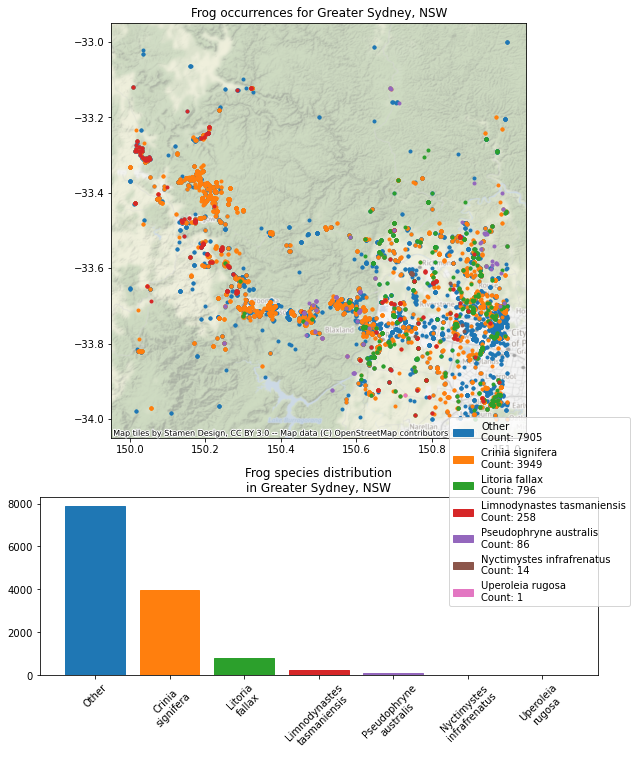

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (10, 12), gridspec_kw={'height_ratios':[0.7, 0.3]})

# Bar chart
bar_data = frog_data.species.value_counts()
barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

# Colour cycle to ensure colors match in both plots
prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
for i, color in zip(range(len(bar_data)), prop_cycle):
    species_name = bar_data.index[i]
    barchart[i].set_color(color['color'])
    barchart[i].set_label(f"{species_name}\nCount: {bar_data[i]}")
    filt = frog_data.species == species_name
    # Scatter plot
    ax[0].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, marker='.', color=color['color'])

# Add other features
ax[0].set_title(f"Frog occurrences for {region_name}")
ax[1].set_title(f"Frog species distribution\nin {region_name}")
cx.add_basemap(ax[0], crs=crs, alpha=0.5) # Add basemap
plt.xticks(rotation=45)
fig.legend(loc=(0.70, 0.2))
plt.show()

#### Sampling Bias: Pseudo-absence

The scatterplot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge. 

One method of addressing the sampling bias inherent in the database is to focus on predicting each species, and to use the occurrence points of other species as absence points. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.


#### Class Balancing

Another issue shown clealy in the barchart is the class imbalance of the frog species. Of the 23 species, only seven of them are present in this area for the given time window, and three of the seven have less than 20 observations. For this demonstration, we will drop these three species, down sample the 'Other' class, and up-sample each of the minority classes to match that of crinia signifera. This is quite a naive approach, so you are encouraged to pursue other more thoughtful ways of addressing this issue.


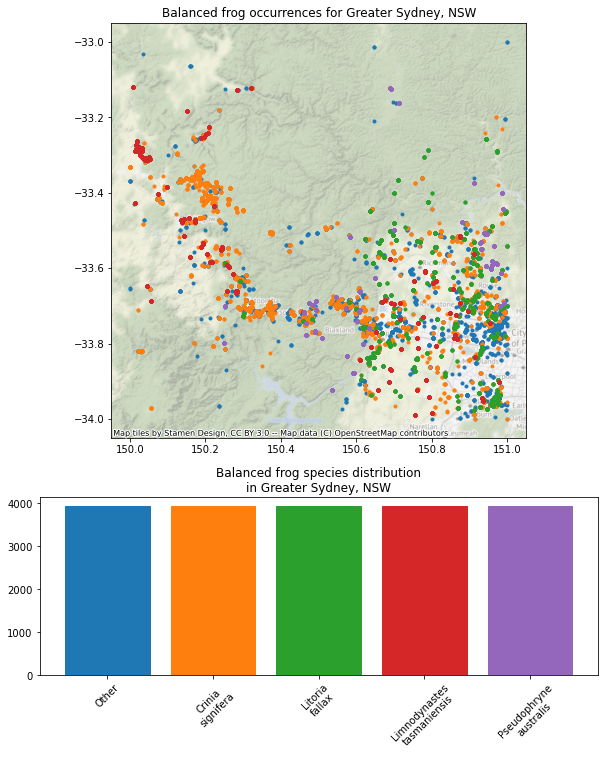

In [7]:
target_counts = bar_data[1]

balanced_frogs = pd.DataFrame()

for species, counts in zip(bar_data.index[0:5], bar_data[0:5]):
    balanced_frogs = balanced_frogs.append(
        frog_data
        [lambda x: x.species == species]
        .sample(target_counts, random_state=420, replace=True)
    )
    
balanced_frogs = balanced_frogs.reset_index(drop=True)

    
    
fig, ax = plt.subplots(2, 1, figsize = (10, 12), gridspec_kw={'height_ratios':[0.7, 0.3]})

# Bar chart
bar_data = balanced_frogs.species.value_counts()
barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

# Colour cycle to ensure colors match in both plots
prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
for i, color in zip(range(len(bar_data)), prop_cycle):
    species_name = bar_data.index[i]
    barchart[i].set_color(color['color'])
    barchart[i].set_label(f"{species_name}\nCount: {bar_data[i]}")
    filt = balanced_frogs.species == species_name
    # Scatter plot
    ax[0].scatter(balanced_frogs[filt].decimalLongitude, balanced_frogs[filt].decimalLatitude, marker='.', color=color['color'])

# Add other features
ax[0].set_title(f"Balanced frog occurrences for {region_name}")
ax[1].set_title(f"Balanced frog species distribution\nin {region_name}")
cx.add_basemap(ax[0], crs=crs, alpha=0.5) # Add basemap
plt.xticks(rotation=45)
# fig.legend(loc=(0.70, 0.3))
plt.show()


After balancing the classes, we finally have our training data visualised below. Again, it must be stressed that this is just one way of addressing the sampling bias inherent in the GBIF data and it does not address the bias completely. Since we will be using this training dataset for evaluation, the evaluation metrics will also contain bias. You are encouraged to improve the training set collection process, particularly the frog absence sampling, until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.

### Predictor Variables

#### TerraClimate

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take six metrics from four assets, namely the mean and overall maximum monthly air temp (`tmax_mean`, `tmax_max`), mean and overall minimum monthly air temp (`tmin_mean`, `tmin_min`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

Because the TerraClimate data has a comparitively lower spatial resolution to the other satellite data, we will need to interpolate this data to match the higher resolution data. To achieve this, the `get_terraclimate` function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates. 

In [8]:
def get_terraclimate(bbox, filename=None, metrics={'mean':{'fn':np.nanmean,'params':{}}}, time_slice=None, assets=None, features=None, interp_dims=None, verbose=False):
    """Returns terraclimate metrics for a given area (or None if filename specified), allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    filename -- string or None. If None, will save result to geotiff. 
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
            
    # Calculate metrics
    combined_data = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        sum_data = sum_data.assign_coords(band = [band+'_'+name for band in sum_data.band.values])
        combined_data.append(sum_data)
        
    # Combine metrics
    combined_data = xr.concat(combined_data, dim='band')
    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
        
    if filename is not None:
        save_to_geotiff(combined_data, filename, bbox)
        return None
    
    return combined_data

#### Planetary Computer
Next, we write a function called `get_pc` that will assist us in grabbing each predictor variable from the planetary computer. It will calculate the median mosaic over the time dimension of each product. 


##### Memory Optimisation

Below we have defined a few helper functions to assist with memory and computational time when querying the planetary computer. The Sentinel-2 data is particularly troublesome due to its high spatial and temporal resolution.

In [9]:
def split_bbox(bbox, n_x, n_y):
    """Splits bounding box into n_x columns and n_y rows"""
    lons = np.linspace(bbox[0],bbox[2], n_x+1)
    lats = np.linspace(bbox[1],bbox[3], n_y+1)
    boxes = []
    for i in range(len(lons)-1):
        for j in range(len(lats)-1):
            boxes.append((lons[i], lats[j], lons[i+1], lats[j+1]))
    return boxes

def scene_overlap(signed_item, bbox_poly):
    """Returns the polygon of the bounding box not covered by the scene"""
    scene_poly = Polygon(signed_item['geometry']['coordinates'][0])
    return bbox_poly.difference(scene_poly)

def get_optimal_coverage(signed_items, bbox, sortby='s2:nodata_pixel_percentage',
                         reverse=False, target_coverage=1.0, scenes_per_hit=1):
    signed_items = sorted(signed_items, key=lambda x: x['properties'][sortby], reverse=reverse)

    bbox_poly = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]],
        [bbox[0], bbox[1]]
    ])
    take_items = []
    remaining_area = Polygon(bbox_poly)
    remaining_area_prev = Polygon(bbox_poly)
    for i, item in enumerate(signed_items):
        remaining_area = Polygon(scene_overlap(item, remaining_area_prev))
        # If item hits new area, take it.
        new_coverage = remaining_area_prev.difference(remaining_area).area/bbox_poly.area
        if new_coverage > 0.0:
            take_items.append(item)
            n_scenes = 1
        else:
            if n_scenes < scenes_per_hit:
                take_items.append(item)
                n_scenes += 1

        # If remaining area is less than the <optimise_coverage> threshold, break
        total_coverage = 1 - remaining_area.area/bbox_poly.area
        if total_coverage >= target_coverage: 
            for j in range(1, scenes_per_hit+1):
                if i+j < len(signed_items):
                    take_items.append(signed_items[i+j])
                    
            print(f'Covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
            print(f'Searched {min(i+scenes_per_hit, len(signed_items))} scenes')
            break
        remaining_area_prev = Polygon(remaining_area)
    else:
        print(f'Only covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
        print(f'Consider refining query parameters')

    signed_items = take_items
    
    return signed_items

In [10]:
# Function to access the planetary computer
def get_pc(product, bbox, filename=None, dims=None, assets={"image/tiff"}, resolution=10, pc_query=None, date_range=None, na_val=None, optimise_coverage_params=None):
    """Return the median mosaic xarray of a specified planetary computer product for a given location
    
    Attributes:
    product -- string representing the planetary computer product
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    assets -- list of assets to take from the product
    resolution -- resolution in meters
    pc_query -- dictionary of arguments to pass to the planetary computer
    date_range -- string representing the date range of the query e.g. '2020-01-01/2020-12-31'
    na_val -- the value representing na values in the dataset. Will be ignored in median calculation
    filename -- string or None. If None, will save result to geotiff.
    """
    
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print('This is the number of scenes that touch our region:',len(items))
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    if optimise_coverage_params is not None:
        signed_items = get_optimal_coverage(signed_items, bbox, **optimise_coverage_params)
    
    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if dims is not None:
        print((data.shape[3], data.shape[2]))
        if dims[0] != data.shape[3] or dims[1] != data.shape[2]:
            print(f"interp_dims not correct. PC returned dims of {(data.shape[3], data.shape[2])}, not {dims}")
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
    
    # Median Composite
    median = data.median(dim="time", skipna=True)
    
    # Rename bands of those with only one band (which otherwise defaults to generic 'data')
    if median.shape[0] == 1:
        median = median.assign_coords(band=[product])
    
    if filename is not None:
        save_to_geotiff(median, filename, bbox)
        return None
    
    return median

##### Feature Engineering: Slope

Additionally, we will calculate the slope from the elevation data. To do this, we define the `slope_pct` function to apply over the elevation data.

In [11]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

Finally, we put all these functions together by writing `get_and_join_data` function. This function will take in our response variable and join on each of the predictor variables from the planetary computer. 

In [12]:
def join_frogs(bbox, data, frogs):
    intersecting_frogs = (
        frogs
        [lambda x: 
         (x.decimalLongitude >= bbox[0]) &
         (x.decimalLatitude >= bbox[1]) &
         (x.decimalLongitude <= bbox[2]) &
         (x.decimalLatitude <= bbox[3])
        ]
    )

    if len(intersecting_frogs) > 0:
        print('merging frogs')
        frogs = frogs.merge(
            (
                data
                .sel(
                    x=xr.DataArray(intersecting_frogs.decimalLongitude, dims="key", coords={"key": intersecting_frogs.key}), 
                    y=xr.DataArray(intersecting_frogs.decimalLatitude, dims="key", coords={"key": intersecting_frogs.key}),
                    method="nearest"
                )
                .to_dataframe()
                .assign(val = lambda x: x.iloc[:, -1])
                .iloc[: , -1:]
                .reset_index()
                .pivot_table(index="key", columns="band", values="val")
            ),
            on = ['key'],
            how = 'inner'
        )[list(data.band.values) + ['key']]
        
    return frogs

def get_and_join_data(products, bbox, all_frogs, split_sen=(10, 10)):
    """collect and download all products"""
        
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        
        if product == 'sentinel-2-l2a':
            sen_frogs = pd.DataFrame()
            for box_num, box in enumerate(split_bbox(bbox, split_sen[0], split_sen[1])):
                print(f'fetching box {box_num+1} of {split_sen[0]*split_sen[1]}')
                data = get_pc(product, box, **params)
                sen_frogs = sen_frogs.append(join_frogs(box, data, all_frogs))
            all_frogs = all_frogs.merge(
                sen_frogs,# .dropna().drop_duplicates()[~sen_frogs.index.duplicated(keep='first')],
                on='key',
                how='left'
            )
            del sen_frogs
        else:
            # Interpolate the weather data to 10m resolution
            if product == 'terraclimate':
                data = get_terraclimate(bbox, **params)
            else:
                data = get_pc(product, bbox, **params)
            # Calculate the gradient of the elevation data
            if product == 'cop-dem-glo-30':
                data_elevation = data.squeeze().drop("band")
                slope_vals = slope_pct(data_elevation, products[product]['resolution'])
                data_slope = xr.DataArray(
                    np.expand_dims(slope_vals, 0),
                    coords=dict(
                        band=['gradient'],
                        y=data_elevation.y,
                        x=data_elevation.x
                    )
                )
                data = xr.concat((data, data_slope), dim='band')
                # remove elevation data from memory
                del data_slope, data_elevation, slope_vals
            all_frogs = all_frogs.merge(
                join_frogs(bbox, data, all_frogs),
                on='key',
                how='left'
            )

    return all_frogs


In [13]:
%%time

# Define products and query parameters for the planetary computer
products = {
    # Land Cover
    "io-lulc":{
        "resolution":10
    },
    # Elevation
    "cop-dem-glo-30":{
        "resolution":10
    },
    # Water extent data
    'jrc-gsw':{
        "resolution":10
    },
    # Sentinel-2 Spectral Band data
    'sentinel-2-l2a':{
        "resolution":10,
        'assets':["B04", "B03", "B02", "B08"],
        'pc_query':{
            "eo:cloud_cover": {"lt": 15}
        },
        'date_range':'2015-01-01/2020-12-31',
        # Take minimum scenes to cover entire area
        'optimise_coverage_params':{
            'sortby':'s2:nodata_pixel_percentage',
            'reverse':False,
            'target_coverage':1.0,
            'scenes_per_hit':3 # With a few extra in case of clouds
        },
        'na_val':0
    },
    # Weather - might need to adjust x_dim, y_dim params to match dimensions of dataarrays above. Off by one errors common.
    "terraclimate":{
        'metrics':{
            'mean':{
                'fn':np.nanmean,
                'params':{}
            },
            'min':{
                'fn':np.nanmin,
                'params':{}
            },
            'max':{
                'fn':np.nanmax,
                'params':{}
            }
        },
        'time_slice':('2015-01-01','2019-12-31'),
        'assets':['tmax', 'tmin', 'ppt', 'soil'],
        'features':['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']
    }
}

product_names={"cop-dem-glo-30":'elevation', "io-lulc":'landcover', 'jrc-gsw':'surface_water', 'sentinel-2-l2a':'sentinel-2'} 

# model_data = get_and_join_data(
#     products, bbox, balanced_frogs.sort_values(['decimalLatitude', 'decimalLongitude']),
#     split_sen=(4, 4)
# )
# model_data = model_data.rename(columns=product_names)
# model_data.to_csv(storage_path+'training.csv', index=None)

model_data = pd.read_csv(storage_path+'training.csv')
print('NAs:')
display(np.sum(model_data.isna()))

model_data = model_data.dropna()

model_data

NAs:


decimalLatitude         0
decimalLongitude        0
speciesKey              0
geometry                0
species                 0
key                     0
landcover               0
elevation               0
gradient                0
change                  0
extent                  0
occurrence              0
recurrence              0
seasonality             0
transitions             0
B04                 15468
B03                 15468
B02                 15468
B08                 15468
tmax_max                0
tmax_mean               0
tmin_min                0
tmin_mean               0
ppt_mean                0
soil_mean               0
dtype: int64

CPU times: user 37.4 ms, sys: 8.38 ms, total: 45.8 ms
Wall time: 50.6 ms


,decimalLatitude,decimalLongitude,speciesKey,geometry,species,key,landcover,elevation,gradient,change,...,B04,B03,B02,B08,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
92,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,5397,2.0,594.291687,12.618931,253.0,...,540.5,473.5,372.5,1456.5,26.300003,16.535002,-0.799999,5.723334,78.383330,96.583336
93,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,5773,2.0,594.291687,12.618931,253.0,...,540.5,473.5,372.5,1456.5,26.300003,16.535002,-0.799999,5.723334,78.383330,96.583336
94,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,7030,2.0,594.291687,12.618931,253.0,...,540.5,473.5,372.5,1456.5,26.300003,16.535002,-0.799999,5.723334,78.383330,96.583336
95,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,7222,2.0,594.291687,12.618931,253.0,...,540.5,473.5,372.5,1456.5,26.300003,16.535002,-0.799999,5.723334,78.383330,96.583336
117,-33.969759,150.055046,2424585,POINT (150.055046 -33.969759),Crinia signifera,4412,2.0,595.149048,4.552698,253.0,...,494.0,392.0,323.5,1221.5,26.300003,16.535002,-0.799999,5.723334,78.383330,96.583336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19161,-33.251192,150.194997,2427754,POINT (150.194997 -33.251192),Other,3214,6.5,551.067200,13.901471,253.0,...,828.0,843.0,579.0,2010.0,29.800003,20.406670,0.100002,7.883334,59.933334,40.066666
19162,-33.251192,150.194997,2424585,POINT (150.194997 -33.251192),Crinia signifera,7097,6.5,551.067200,13.901471,253.0,...,828.0,843.0,579.0,2010.0,29.800003,20.406670,0.100002,7.883334,59.933334,40.066666
19163,-33.251192,150.194997,2424585,POINT (150.194997 -33.251192),Crinia signifera,7742,6.5,551.067200,13.901471,253.0,...,828.0,843.0,579.0,2010.0,29.800003,20.406670,0.100002,7.883334,59.933334,40.066666
19164,-33.251121,150.195039,2424585,POINT (150.195039 -33.251121),Crinia signifera,5181,7.0,550.960754,10.876266,253.0,...,819.0,776.0,528.0,1964.0,29.800003,20.406670,0.100002,7.883334,59.933334,40.066666


#### Recoding categorical variables

The landcover data is a categorical variable, where a number from 1 to 10 represents a given terrain. Below we recode this into one-hot encoding, a binary variable for each terrain indicating what terrain the pixel is. This is necessary for certain models like logistic regression which we aim to use in this demonstration.

In [14]:
landcover_mapper = {
    1:  'lc_water', 
    2:  'lc_trees', 
    3:  'lc_grass',
    4:  'lc_flooded_vegetation', 
    5:  'lc_crops',
    6:  'lc_scrub', 
    7:  'lc_urban', 
    8:  'lc_bare_soil',
    9:  'lc_snow_ice', 
    10: 'lc_clouds'
}

JRC_transitions_mapper = {
    1:  "JRC_tr_permanent", 
    2:  "JRC_tr_new_permanent", 
    3:  "JRC_tr_lost_permanent", 
    4:  "JRC_tr_seasonal", 
    5:  "JRC_tr_new_seasonal", 
    6:  "JRC_tr_lost_seasonal", 
    7:  "JRC_tr_seasonal_to_permanent", 
    8:  "JRC_tr_permanent_to_seasonal", 
    9:  "JRC_tr_ephemeral_permanent", 
    10: "JRC_tr_ephemeral_seasonal"
}

model_data = (
    model_data
    .merge(
        pd.get_dummies(
            model_data.landcover.astype(int).map(landcover_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("landcover", 1)
    .merge(
        pd.get_dummies(
            model_data.transitions.astype(int).map(JRC_transitions_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("transitions", 1)
)

model_data.head()

,decimalLatitude,decimalLongitude,speciesKey,geometry,species,key,elevation,gradient,change,extent,...,lc_flooded_vegetation,lc_grass,lc_scrub,lc_trees,lc_urban,lc_water,JRC_tr_new_permanent,JRC_tr_new_seasonal,JRC_tr_permanent,JRC_tr_seasonal
0,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,5397,594.291687,12.618931,253.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,5773,594.291687,12.618931,253.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,7030,594.291687,12.618931,253.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,-33.972231,150.055630,2424585,POINT (150.05563 -33.972231),Crinia signifera,7222,594.291687,12.618931,253.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,-33.969759,150.055046,2424585,POINT (150.055046 -33.969759),Crinia signifera,4412,595.149048,4.552698,253.0,0.0,...,0,0,0,1,0,0,0,0,0,0


### Model Building

#### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [15]:
from sklearn.linear_model import LogisticRegression


full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(["decimalLatitude", "decimalLongitude", "speciesKey", "geometry", "species", "key"], 1)
)
y = model_data.species


For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section.

In [16]:
full_model.fit(X, y)

LogisticRegression()

#### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To visualise this, we need to understand that each pixel on our satellite image has an associated $k$ dimensional vector of predictor variable values, in this case $k=13$ bands relating to elevation data, landcover, JRC water extent, and Sentinel-2 data. Thus, we can associate a $k$ band image with any satellite image. For each of those $k$ band pixels, we can use our logistic regression model to output the probability of a frog being found there. Finally, we can visualise this as a heatmap which will show regions that our model thinks are likely frog habitats.


#### In-Sample Evaluation

Now that we have visualised the model on the Richmond area, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance -  so don't get too excited!


In [17]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions, average='macro')}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.5918537734172151
Accuracy: 0.6034603694178162


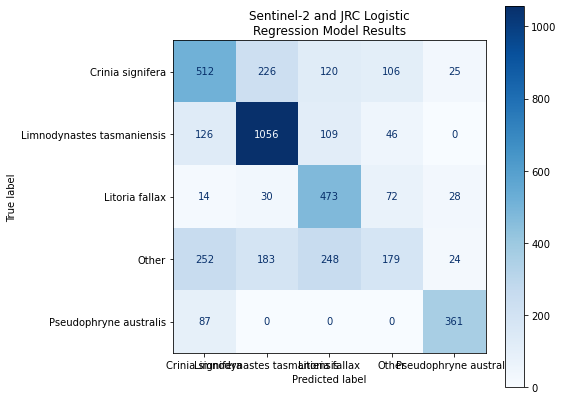

In [18]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Sentinel-2 and JRC Logistic\nRegression Model Results')
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.


In [19]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
metric_params = {'F1': {'average':'macro'}, 'Accuracy': {}}
results = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        results[metric].append(fn(y_test, predictions, **metric_params[metric]))
        
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in results.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.59
Accuracy: 0.59


### Submission

Now that we have generated a model using data from one area, how do we apply that model to other areas? To do this, we need to write some functions that will allow us to automatically pull the required data for an arbitrary location. Specifically, we need to be able to pull all the predictor variables for a given location, as well as the actual frog sightings in that location for reference. These functions will reuse much of the code from prior notebooks, so we won't go into too much detail.


#### Test Areas

For this, we will use Hornsby, NSW as an example.

In [20]:
test_regions = {
    'nsw':{
        'title':"Berowra Valley National Park, NSW, Australia",
        'bbox':(151.02, -33.73, 151.12, -33.63)
    },
    'cr':{
        'title':"Corcovado National Park, Puntarenas Province, Costa Rica",
        'bbox':(-83.49,8.51,-83.39,8.61)
    },
    'sa':{
        'title':"Cape Town, South Africa",
        'bbox':(18.40,-34.10,18.50,-34.00)
    }
}

for key, region in test_regions.items():
    region['frogs'] = get_frogs(region['bbox'], {"year":"2015,2019"}, verbose=False)



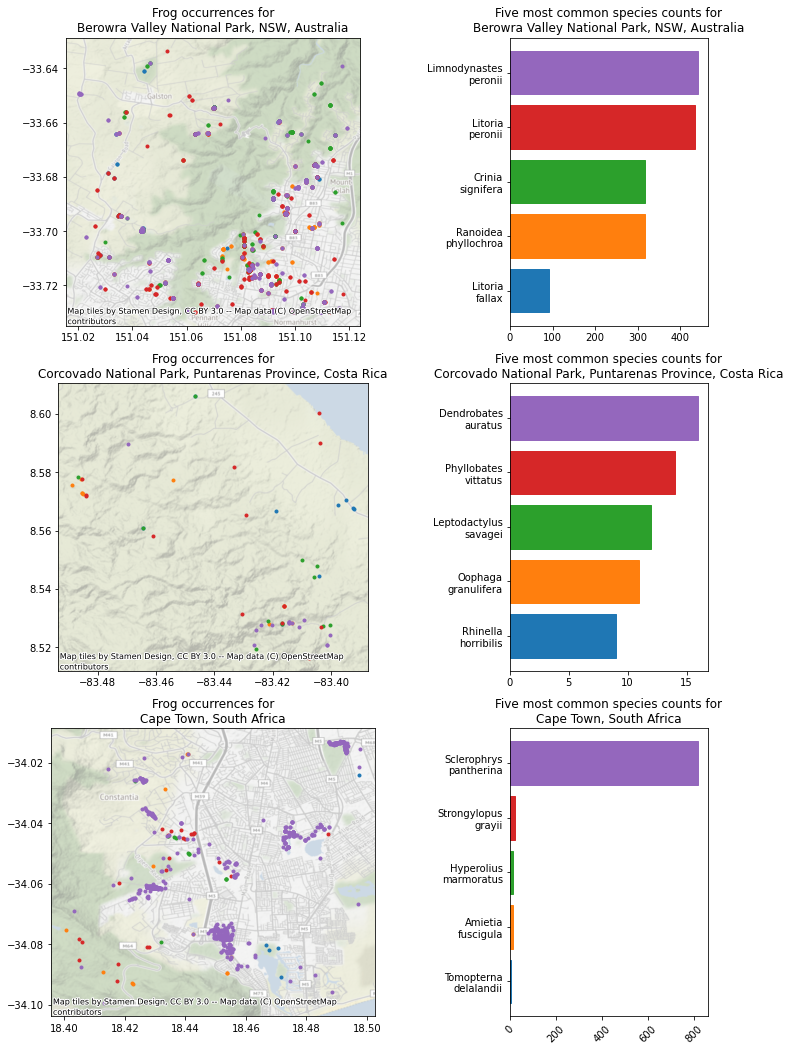

In [21]:

fig, ax = plt.subplots(len(test_regions), 2, figsize = (13, 6*len(test_regions)), gridspec_kw={'width_ratios':[0.7, 0.3]})


for row, region in enumerate(test_regions.values()):
    bbox = region['bbox']
    region_name = region['title']
    frogs = region['frogs']
    
    
    
    # Bar chart
    bar_data = frogs.species.value_counts()[0:5]
    bar_data = bar_data[::-1]
    barchart = ax[row, 1].barh(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{species_name}\nCount: {bar_data[i]}")
        filt = frogs.species == species_name
        # Scatter plot
        ax[row, 0].scatter(frogs[filt].decimalLongitude, frogs[filt].decimalLatitude, marker='.', color=color['color'])

    # Add other features
    ax[row, 0].set_title(f"Frog occurrences for\n{region_name}")
    ax[row, 1].set_title(f"Five most common species counts for\n{region_name}")
    cx.add_basemap(ax[row, 0], crs=crs, alpha=0.5) # Add basemap
    plt.xticks(rotation=45)
    

Next, we obtain the predictor variables from the planetary computer.

In [22]:
def save_to_geotiff(arr, filename, bbox, dtype='uint16'):
    # If filename is specified, save mosaic to geotiff  
    bands = arr.shape[0]
    height = arr.shape[1]
    width = arr.shape[2]
    print(arr.shape)
        
    # write bandnames to separate file
    with open(filename+'.bands', 'w') as file:
        file.write(','.join(arr.band.values))
        
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
    # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
    gt = rasterio.transform.from_bounds(min_lon, min_lat, max_lon, max_lat, width, height)
    arr.rio.write_crs("epsg:4326", inplace=True)
    arr.rio.write_transform(transform=gt, inplace=True);
    
    # Create the GeoTIFF output file using the defined parameters
    with rasterio.open(filename+'.tiff', 'w', driver='GTiff', width=width, height=height, crs='epsg:4326',
                       transform=gt, count=bands, compress='lzw', dtype=dtype) as dst:
        for band in range(bands):
            print(f'writing {band+1} of {bands}')
            dst.write(arr[band],band+1)
        dst.close()

In [23]:
def save_predictor_datasets(products, bbox, path, interp_dims=(512, 512)):
    """collect and download all products"""
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        
        # Interpolate the weather data to 10m resolution
        if product == 'terraclimate':
            get_terraclimate(bbox, filename=path+product, interp_dims=interp_dims, **params)
        elif product == 'cop-dem-glo-30':
            # Don't specify filename so that the array is returned and we can calculate the slope
            data = get_pc(product, bbox, dims=interp_dims, **params)
        else:
            get_pc(product, bbox, dims=interp_dims, filename=path+product, **params)

        # Calculate the gradient of the elevation data
        if product == 'cop-dem-glo-30':
            data_elevation = data.squeeze().drop("band")
            slope_vals = slope_pct(data_elevation, products[product]['resolution'])
            data_slope = xr.DataArray(
                np.expand_dims(slope_vals, 0),
                coords=dict(
                    band=['gradient'],
                    y=data_elevation.y,
                    x=data_elevation.x
                )
            )
            data.assign_coords(band=['elevation'])
            data = xr.concat((data, data_slope), dim='band')
            save_to_geotiff(data, path+product, bbox)
            
            # remove elevation data from memory
            del data, data_slope, data_elevation, slope_vals

In [24]:
# Define products and query parameters for the planetary computer

# convert degrees to pixels for crs=4326 
x_dim = int((max_lon - min_lon)*111320.0/10+1)
y_dim = int((max_lat - min_lat)*111320.0/10+1)  

print(x_dim, y_dim)


key = 'nsw'

if not os.path.exists(storage_path+key+'/'):
    os.mkdir(storage_path+key)


save_predictor_datasets(products, test_regions[key]['bbox'], storage_path+key+'/', interp_dims=(x_dim, y_dim))

11133 11133
loading io-lulc
This is the number of scenes that touch our region: 2
(1114, 1114)
interp_dims not correct. PC returned dims of (1114, 1114), not (11133, 11133)
(1, 1114, 1114)
writing 1 of 1
loading cop-dem-glo-30
This is the number of scenes that touch our region: 1
(1114, 1114)
interp_dims not correct. PC returned dims of (1114, 1114), not (11133, 11133)
(2, 1114, 1114)
writing 1 of 2
writing 2 of 2
loading jrc-gsw
This is the number of scenes that touch our region: 1
(1114, 1114)
interp_dims not correct. PC returned dims of (1114, 1114), not (11133, 11133)
(6, 1114, 1114)
writing 1 of 6
writing 2 of 6
writing 3 of 6
writing 4 of 6
writing 5 of 6
writing 6 of 6
loading sentinel-2-l2a
This is the number of scenes that touch our region: 182
Covered 100.0% with 4 scenes
Searched 3 scenes
(1114, 1114)
interp_dims not correct. PC returned dims of (1114, 1114), not (11133, 11133)
(4, 1114, 1114)
writing 1 of 4
writing 2 of 4
writing 3 of 4
writing 4 of 4
loading terraclimate
(

Create predictor geotiff

In [25]:
landcover_mapper = {
    1:  'lc_water', 
    2:  'lc_trees', 
    3:  'lc_grass',
    4:  'lc_flooded_vegetation', 
    5:  'lc_crops',
    6:  'lc_scrub', 
    7:  'lc_urban', 
    8:  'lc_bare_soil',
    9:  'lc_snow_ice', 
    10: 'lc_clouds'
}

JRC_transitions_mapper = {
    1:  "JRC_tr_permanent", 
    2:  "JRC_tr_new_permanent", 
    3:  "JRC_tr_lost_permanent", 
    4:  "JRC_tr_seasonal", 
    5:  "JRC_tr_new_seasonal", 
    6:  "JRC_tr_lost_seasonal", 
    7:  "JRC_tr_seasonal_to_permanent", 
    8:  "JRC_tr_permanent_to_seasonal", 
    9:  "JRC_tr_ephemeral_permanent", 
    10: "JRC_tr_ephemeral_seasonal"
}


all_datasets = []
all_bands = []
for file in products.keys():
    
    # Get bands
    with open(f'{storage_path}{key}/{file}.bands', 'r') as band_file:
        bands = band_file.readline().split(',')
    
    # Make separate masks for io-lulc landcover (one-hot encoding)
    if file == 'io-lulc':
        for i in range(1, 11):
            if landcover_mapper[i] in model_data.columns:
                all_datasets.append(xr.open_rasterio(f'{storage_path}{key}/{file}.tiff').assign_coords(band=[landcover_mapper[i]]) == i)
                all_bands.append(landcover_mapper[i])
    elif file == 'jrc-gsw':
        jrc_data = xr.open_rasterio(f'{storage_path}{key}/{file}.tiff').assign_coords(band=bands)
        for jrc_band in bands:
            if jrc_band == 'transitions':
                for i in range(1, 11):
                    if JRC_transitions_mapper[i] in model_data.columns:
                        all_datasets.append(
                            (jrc_data.sel(band=jrc_band) == i).assign_coords(band=JRC_transitions_mapper[i])
                        )
                        all_bands.append(JRC_transitions_mapper[i])
            else:
                all_datasets.append(
                    jrc_data.sel(band=jrc_band)
                )
                all_bands.append(JRC_transitions_mapper[i])
    else:
        all_datasets.append(
            xr.open_rasterio(f'{storage_path}{key}/{file}.tiff').assign_coords(band=bands)
        )
        all_bands.extend(bands)

In [29]:
for col in X.columns:
    

Index(['elevation', 'gradient', 'change', 'extent', 'occurrence', 'recurrence',
       'seasonality', 'B04', 'B03', 'B02', 'B08', 'tmax_max', 'tmax_mean',
       'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean', 'lc_bare_soil',
       'lc_crops', 'lc_flooded_vegetation', 'lc_grass', 'lc_scrub', 'lc_trees',
       'lc_urban', 'lc_water', 'JRC_tr_new_permanent', 'JRC_tr_new_seasonal',
       'JRC_tr_permanent', 'JRC_tr_seasonal'],
      dtype='object')
